# Procedimiento

In [1]:
import numpy as np
import cv2
import os, os.path
import skimage
from  skimage.feature import hog

## A. Entrenamiento para el reconocimiento de los caracteres

El proceso inicia entrenando un algoritmo de Support Vector Machine (SVM). El set de entrenamiento consiste en diversas letras y números repartidos entre más de mil imágenes, de las cuales se usará el 80%. El descriptor utilizado para las imágenes es un Histograma de Gradientes Orientados (HOG).

In [2]:
from simplelibrary import *
from simplesvm import *

T=[]
LT=[]

for label in labels:
    size = len(dic[label])
    for im in dic[label][int(size * percentage):]:
        auxIm = cv2.imread(imageDir + '/entrenamiento/' + im, 0)
        auxIm = normalizeImage(auxIm)
        fd=hog(auxIm, orientations = 8, pixels_per_cell = (ppc, ppc), cells_per_block = (1, 1))
        
        T.append(fd)
        LT.append(label)

T = np.vstack(T)
T = np.float32(T)

LT = np.vstack(LT)

result = svm.predict(T)[1]
mask = result == LT
correct = np.count_nonzero(mask)

print(correct * 100.0/ result.size)

/usr/local/lib/python3.4/dist-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


99.6268656716418


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

## B. Preprocesamiento de la imagen

Es necesario hacerle cambios previos a la imagen original antes de intentar identificar la placa del carro. Para este ejemplo, usaremos la imagen P6070001.jpg del dataset. Los cambios correspondientes son, en este orden:

* Convertir la imagen a escala de gris y aplicarle un filtro gaussiano
* Aumentar el contraste de la imagen para acentuar los bordes (Thresholding)
* Identificar todos los bordes la imagen

Adicionalmente, se limpia el arreglo de bordes para disminuir el ruido.

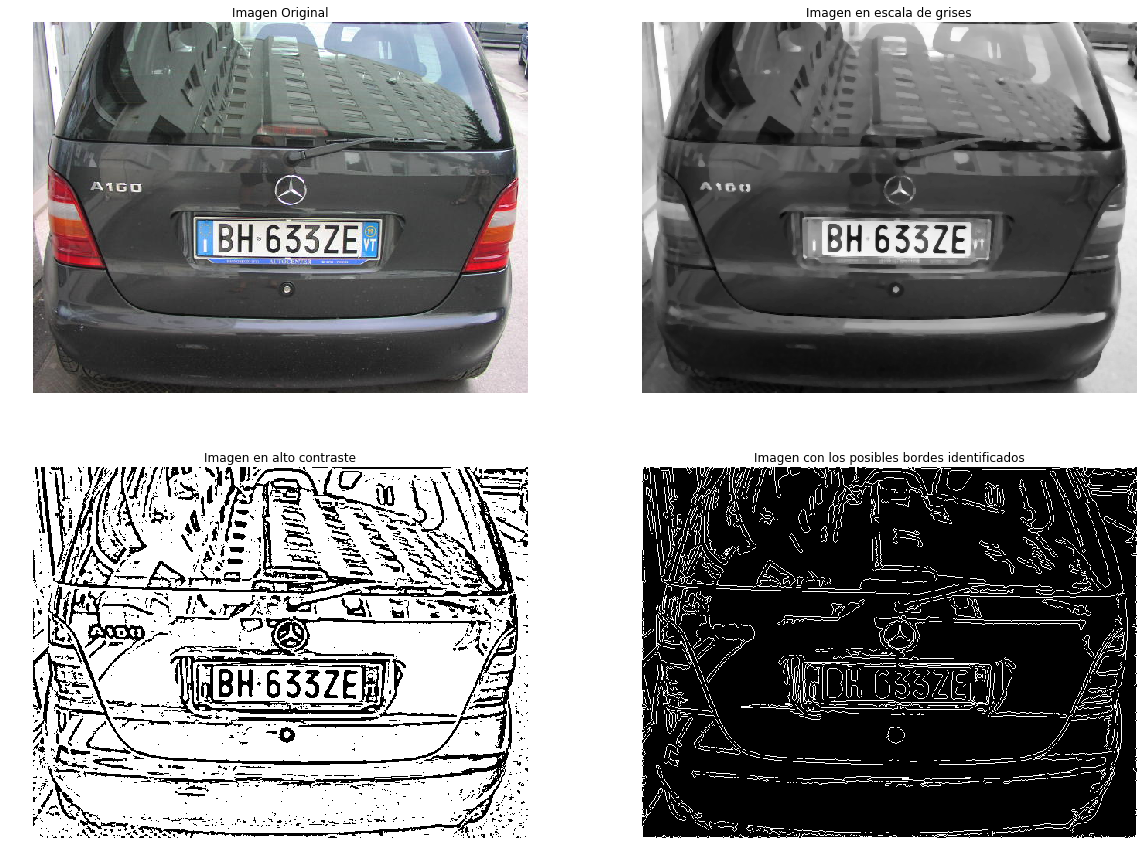

In [4]:
# Leer la imagen

img = cv2.imread(imageDir + '/070603/P6070001.jpg')

height, width, numChannels = img.shape

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Convertir la imagen a escala de gris y aplicarle un filtro gaussiano

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_blur = cv2.medianBlur(img_gray, 5)

# Aumentar el contraste de la imagen para acentuar los bordes (Thresholding)

th3 = cv2.adaptiveThreshold(img_blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)

# Identificar todos los bordes la imagen

_, contours, _ = cv2.findContours(th3.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

## Limpiar los contornos muy pequeños

contours = list(filter(lambda x: isLetter(x), contours))

img_c = cv2.drawContours(np.zeros((height, width, 3), np.uint8), contours, -1, (255,255,255), 1)

# Mostrar las imágenes

fig = plt.figure(figsize=(20, 15))

fig.add_subplot(2, 2, 1)
plt.title('Imagen Original')
plt.imshow(img_rgb)
plt.axis('off')

fig.add_subplot(2, 2, 2)
plt.title('Imagen en escala de grises')
plt.imshow(img_blur, 'gray')
plt.axis('off')

fig.add_subplot(2, 2, 3)
plt.title('Imagen en alto contraste')
plt.imshow(th3, 'gray')
plt.axis('off')

fig.add_subplot(2, 2, 4)
plt.title('Imagen con los posibles bordes identificados')
plt.imshow(img_c)
plt.axis('off')
plt.show()

## C. Identificación de la placa

La heurística para identificar una placa se basa en dos criterios: Diferencia de dimensiones de un caracter con respecto a otros caracteres y el alineamiento con ellos.

La diferencia de altura con otros caracteres es de máximo el 10%. La diferencia en el ancho, sin embargo, puede tolerar hasta el 400% de diferencia. Esto es debido a caracteres como 'L' o '1' los cuales son muy delgados y suelen pasar de largo.

Las letras de las placas de los carros suelen estar a la misma altura, por lo que se permite una diferencia de posición vertical máxima de 10 pixeles.

Estas dos condiciones suelen ser suficientes para identificar distintas cadenas de caracteres similares. Una última heurística es aplicada al tomar la cadena con mayor longitud, asumiendo que solo los caracteres de las placas de los carros pueden tener el más alto número de coincidencias.

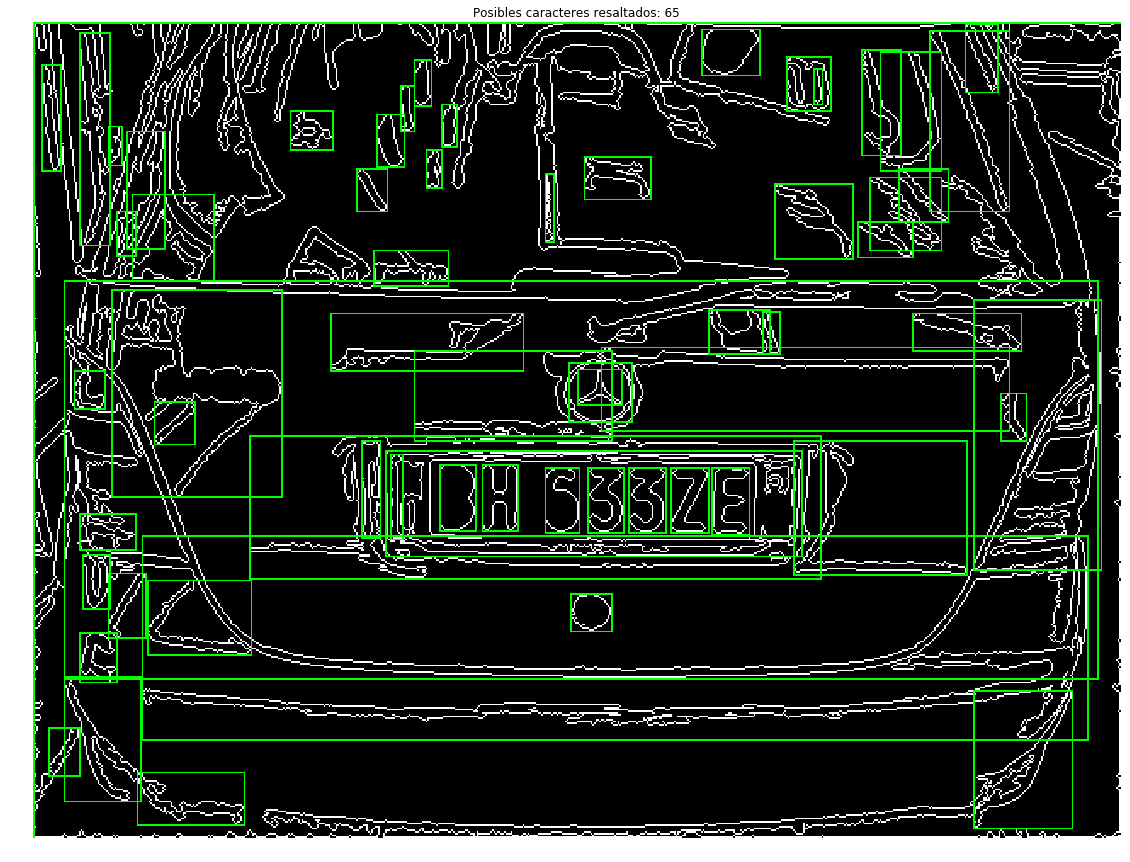

In [5]:
img_allC = cv2.drawContours(np.zeros((height, width, 3), np.uint8), contours, -1, (255,255,255), 1)

for c in contours:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(img_allC,(x,y),(x+w,y+h),(0,255,0),1)

plt.figure(figsize=(20, 15))
plt.title('Posibles caracteres resaltados: ' + str(len(contours)))
plt.imshow(img_allC)
plt.axis('off')
plt.show()

Luego de esto podemos obtener la lista de bordes que pertenecen a la placa del carro.

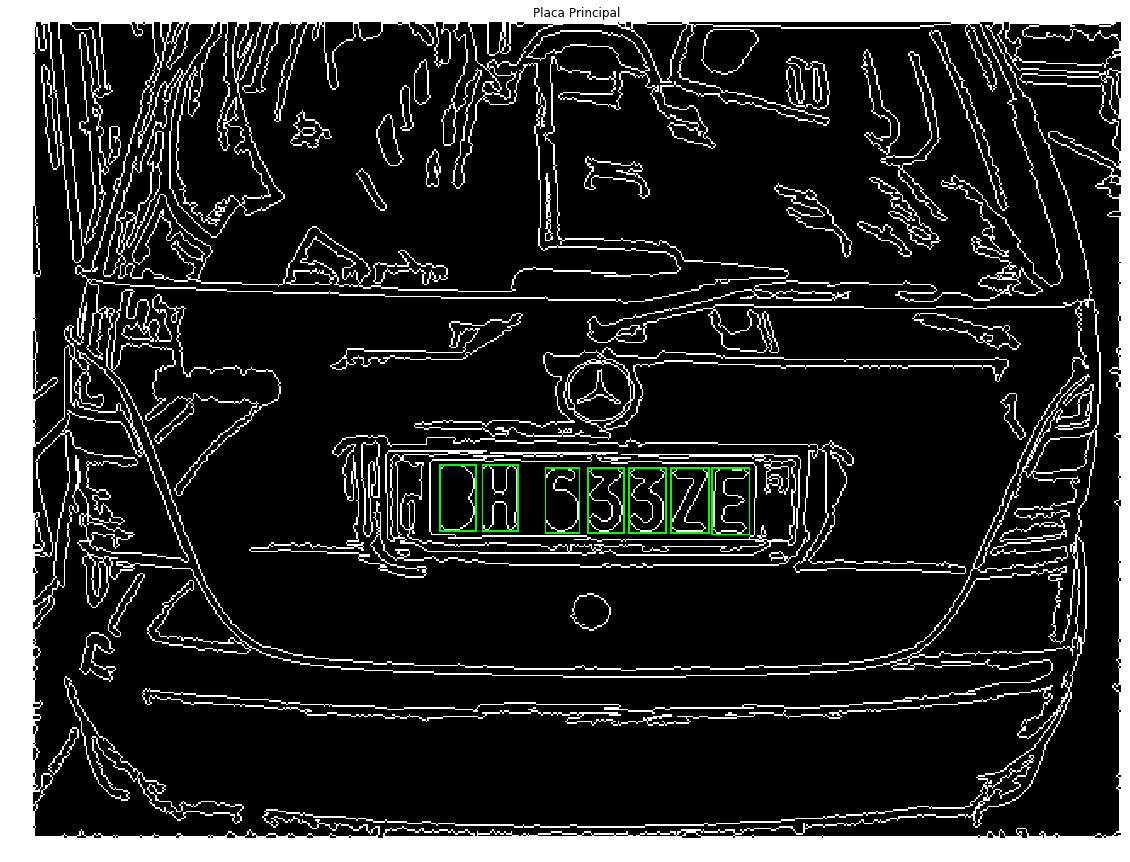

In [6]:
possiblePlates = []

for c in contours:
    possiblePlate = []
    for c1 in contours:
        if areSimilar(c, c1):
            possiblePlate.append(c1)
    possiblePlates.append(possiblePlate)

possiblePlates.sort(key=len)

mainPlate = possiblePlates[-1]
mainPlate.sort(key=lambda x: orderFromLeft(x))

img_mainC = cv2.drawContours(img_c.copy(), mainPlate, -1, (255,255,255), 1)

for letter in mainPlate:
    x,y,w,h = cv2.boundingRect(letter)
    cv2.rectangle(img_mainC,(x,y),(x+w,y+h),(0,255,0),1)

plt.figure(figsize=(20, 15))
plt.title('Placa Principal')
plt.imshow(img_mainC)
plt.axis('off')
plt.show()

El tipo de variable de mainPlate es una lista de coordenadas. Para poder usar la SVM previamente entrenada, hay que usar esas coordenadas para recortar la imagen original y guardar los fragmentos en otro arreglo.

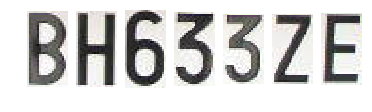

In [7]:
letterImageArray = []

for letter in mainPlate:
    x,y,w,h = cv2.boundingRect(letter)
    img_letter = img_rgb[y:y+h,x:x+w]
    letterImageArray.append(img_letter)

fig = plt.figure()
number_of_files = len(letterImageArray)
for i in range(number_of_files):
    a=fig.add_subplot(1,number_of_files,i+1)
    plt.imshow(letterImageArray[i], cmap='Greys_r')
    plt.axis('off')

## D. Reconocimiento de caracteres¶

Finalmente, se calcula el Histograma de Gradientes Orientados de las imagenes recortadas y se imprime el resultado, que en este caso coincide con la placa observada: BH635ZE

In [8]:
P = []
    
for letter in letterImageArray:
    auxl = normalizeImage2(letter)
    fd=hog(auxl, orientations = 8, pixels_per_cell = (ppc, ppc), cells_per_block = (1, 1))
    P.append(fd)

P = np.vstack(P)
P = np.float32(P)

result = svm.predict(P)[1]
mask = result == LT
correct = np.count_nonzero(mask)
plate = [ chr(c) for c in result ]
print("Placa reconocida:", ''.join(plate))

Placa reconocida: BH633ZE


/usr/local/lib/python3.4/dist-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if sys.path[0] == '':
